# Regime Prediction Models for the Indian Market

### Data Sources:
1. Yahoo Finance
2. Trendlyne
3. Ticker Tape
4. FRED
5. OCED
6. JKP Factor Liibrary
7. Money Control

### Macro Features:
1. Inflation
2. Interest Rate
3. USD / INR Exchange Rate
4. Global Equity Returns
5. Leading Composite Index
6. Market Cap to GDP Ratio

### Investor Sentiment Features:
1. Ticker Tape Mood Index

### Idiosyncratic Features
1. P/E
2. Momentum - 1, 6, months


In [291]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from fredapi import Fred


# Turn off warnings
warnings.filterwarnings("ignore")

### NIFTY 50 Historical Data
We get latest data from yahoo finance and combine it with older data

In [292]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
yf_market_data = data['Close'].resample('ME').last()

display(yf_market_data.head())


nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:yf_market_data.index[0]-pd.DateOffset(days=15)]

display(nifty_historical.tail())
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

[*********************100%***********************]  1 of 1 completed


Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195


,Index Name,Open,High,Low,Close
Date,,,,,
2007-04-30,NIFTY 50,4081.60,4096.90,4028.90,4087.90
2007-05-31,NIFTY 50,4250.25,4306.75,4250.25,4295.80
2007-06-30,NIFTY 50,4282.40,4321.35,4280.95,4318.30
2007-07-31,NIFTY 50,4444.25,4534.20,4432.85,4528.85
2007-08-31,NIFTY 50,4412.60,4471.30,4403.00,4464.00


,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2025-08-31,24426.849609
2025-09-30,24611.099609
2025-10-31,25722.099609


Plot NIFTY 50 historical cummulative returns

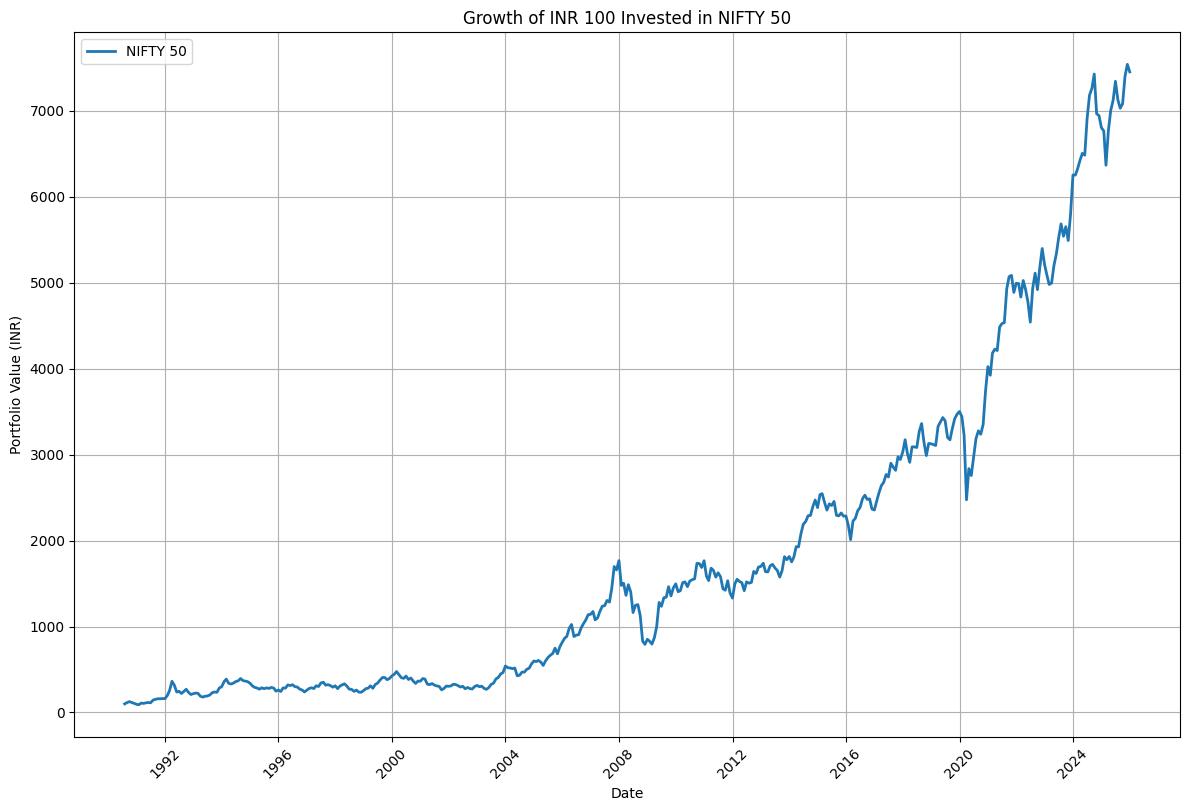

In [293]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Create Next Month Return Column

In [294]:
market_data['next_month_return'] = market_data['Return'].shift(-1)
market_data.head()

,^NSEI,Return,Portfolio,next_month_return
Date,,,,
1990-07-31,347.44,NaN,100.000000,0.151451
1990-08-31,400.06,0.151451,115.145061,0.099135
1990-09-30,439.72,0.099135,126.559982,-0.082007
1990-10-31,403.66,-0.082007,116.181211,-0.089110
1990-11-30,367.69,-0.089110,105.828344,-0.100166


In [295]:
features_df_list = []


## Adding Idiosyncratic Features

### 1. Momentum

In [296]:
market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1) - 1
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3) - 1
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6) - 1


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1
Date,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN
1990-12-31,330.86,-0.100166,95.227953,-0.049870,-0.100166,-0.247567,NaN
1991-01-31,314.36,-0.049870,90.478932,0.208614,-0.049870,-0.221226,-0.095211
1991-02-28,379.94,0.208614,109.354133,-0.035506,0.208614,0.033316,-0.050292
1991-03-31,366.45,-0.035506,105.471448,0.061564,-0.035506,0.107568,-0.166629


### 2. Sensex P/E

In [297]:
sheet_id = "1ZcT4v4PzjwACcbzmwYXGwxLMRXtuQGwsSEPyONMcfcU"
sheet_name = "Sheet1"  # or your specific sheet name

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

cape = pd.read_csv(url)
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()

features_df_list.append(cape[['P/E']])
display(cape.head())
# market_data = pd.merge(market_data,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
# market_data.head()

,BSE Sensex CAPE 5,Sensex Close Price,P/E,EPS,Inflation Rate,Inflation Adjusted EPS,Inflation Adjusted Price,Last 120 Month EPS Inflation Adj
Date,,,,,,,,
1995-04-30,35.67,3133.28,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,33.25,3351.48,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,33.69,3247.36,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-31,32.58,3386.97,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-31,32.55,3346.76,NaN,NaN,NaN,NaN,NaN,NaN


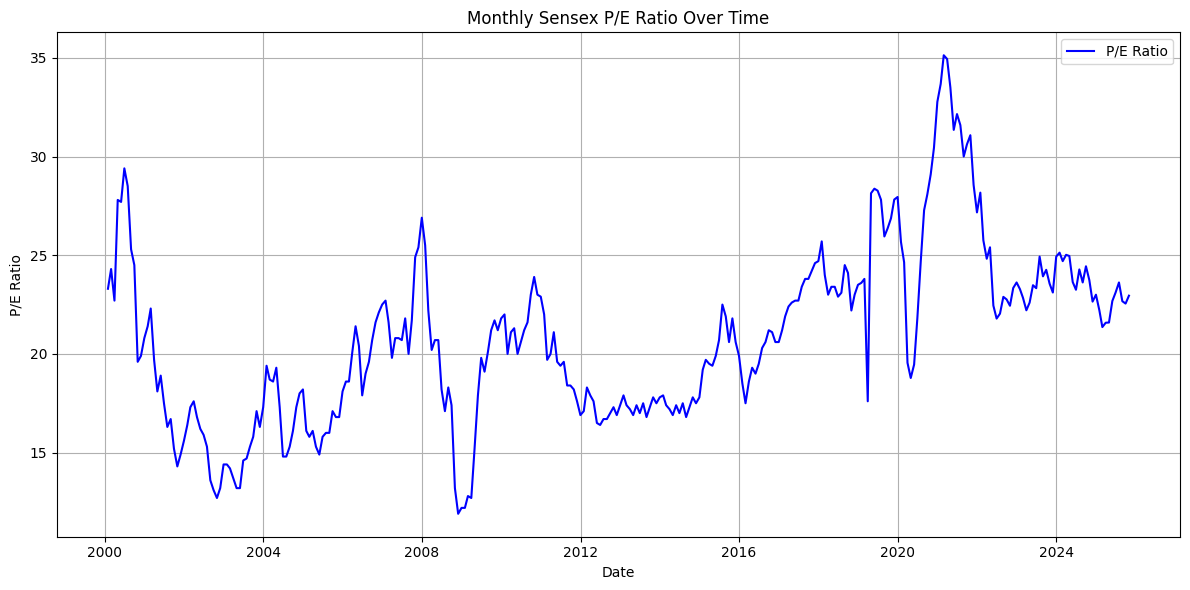

In [298]:
plt.figure(figsize=(12,6))
plt.plot(cape.index, cape['P/E'], label='P/E Ratio', color='blue')
plt.xlabel('Date')
plt.ylabel('P/E Ratio')
plt.title('Monthly Sensex P/E Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Low Risk Factor

In [299]:
low_risk = pd.read_csv("./data/[ind]_[low_risk]_[monthly]_[vw_cap].csv")
low_risk = low_risk[['date', 'ret']]
low_risk["date"] = pd.to_datetime(low_risk["date"])
low_risk = low_risk.set_index("date")
low_risk = low_risk.rename(columns={
    "ret":"low_risk"
})

features_df_list.append(low_risk[['low_risk']])

low_risk.tail()

,low_risk
date,
2024-08-31,0.010172
2024-09-30,0.014639
2024-10-31,-0.001784
2024-11-30,-0.018924
2024-12-31,-0.007749


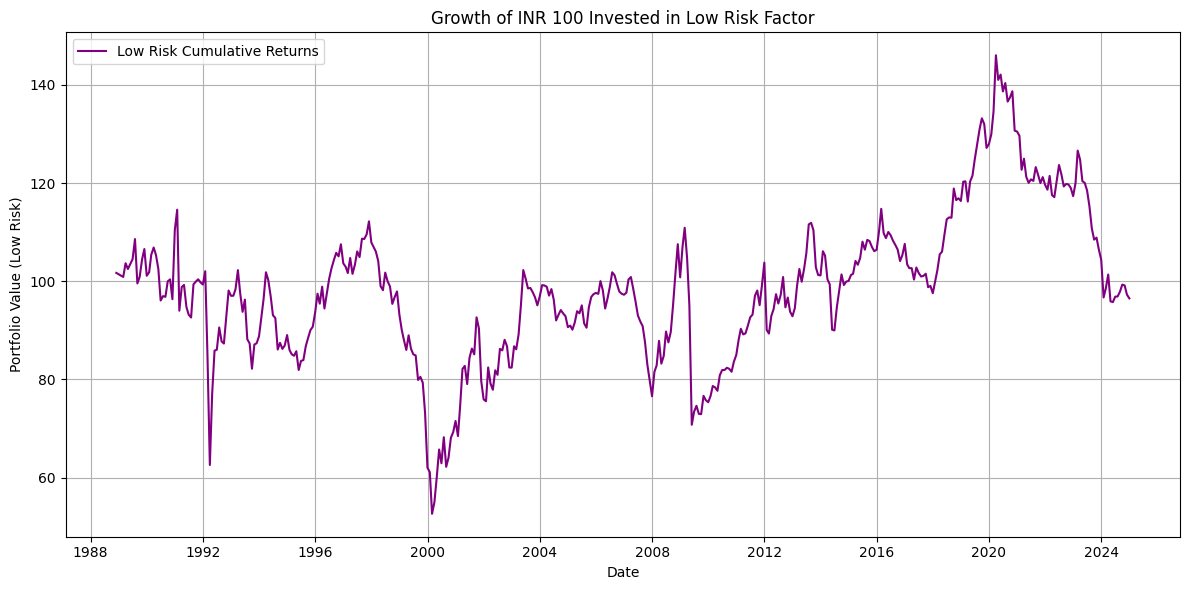

In [300]:
initial_value = 100
low_risk_cumm = initial_value * (1 + low_risk['low_risk'].fillna(0)).cumprod()
plt.figure(figsize=(12,6))
plt.plot(low_risk.index, low_risk_cumm, label='Low Risk Cumulative Returns', color='purple')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Low Risk)')
plt.title('Growth of INR 100 Invested in Low Risk Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Momentum Factor

In [301]:
momentum = pd.read_csv("./data/[ind]_[momentum]_[monthly]_[vw_cap].csv")
momentum = momentum[['date', 'ret']]
momentum["date"] = pd.to_datetime(momentum["date"])
momentum = momentum.set_index("date")
momentum = momentum.rename(columns={"ret": "momentum"})

features_df_list.append(momentum[['momentum']])

momentum.tail()

,momentum
date,
2024-08-31,-0.002884
2024-09-30,-0.009180
2024-10-31,0.004541
2024-11-30,0.011476
2024-12-31,0.027236


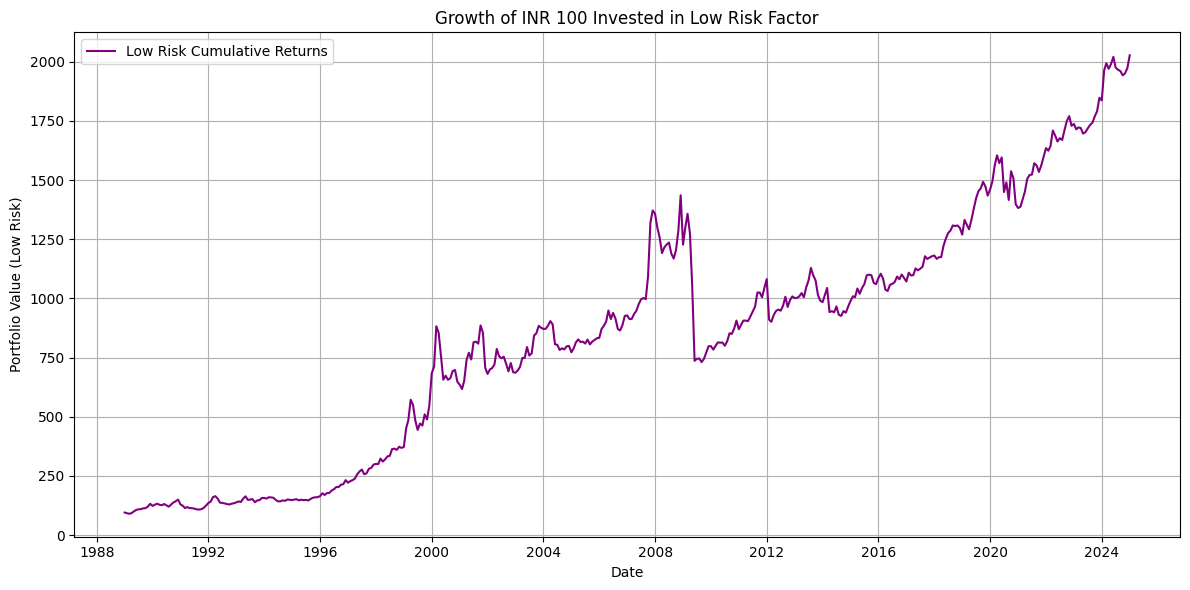

In [302]:
initial_value = 100
momentum_cumm = initial_value * (1 + momentum['momentum'].fillna(0)).cumprod()
plt.figure(figsize=(12,6))
plt.plot(momentum.index, momentum_cumm, label='Low Risk Cumulative Returns', color='purple')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Low Risk)')
plt.title('Growth of INR 100 Invested in Low Risk Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Macro Economic Features

### 1. Inflation

In [303]:
# Step 2: Initialize the FRED API with your API key
# (Get one for free from https://fred.stlouisfed.org/docs/api/api_key.html)
fred = Fred(api_key='8b995803b3d5488cc5f5dcaaedb698ff')

# # Step 3: Fetch the data
# series_id = 'INDCPIALLMINMEI'
# inflation_data = fred.get_series(series_id)

# # Step 4: Convert to DataFrame for easier handling
# inflation_df = pd.DataFrame(inflation_data, columns=['CPI'])
# inflation_df.index.name = 'Date'

# inflation_df = inflation_df.resample('ME').last()
# inflation_df['inflation_rate'] = inflation_df['CPI'].pct_change()

inflation_df = pd.read_csv('data/india_inflation.csv')
inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])
inflation_df = inflation_df.set_index('Date')

features_df_list.append(inflation_df[['inflation_rate']])
display(inflation_df.tail())
# market_data = pd.merge(market_data,inflation_df[['inflation_rate']], left_index=True, right_index=True, how='left')
# market_data.head()

,CPI,inflation_rate
Date,,
2025-06-30,0.0,0.021
2025-07-31,0.0,0.016
2025-08-31,0.0,0.021
2025-09-30,0.0,0.014
2025-10-31,0.0,0.003


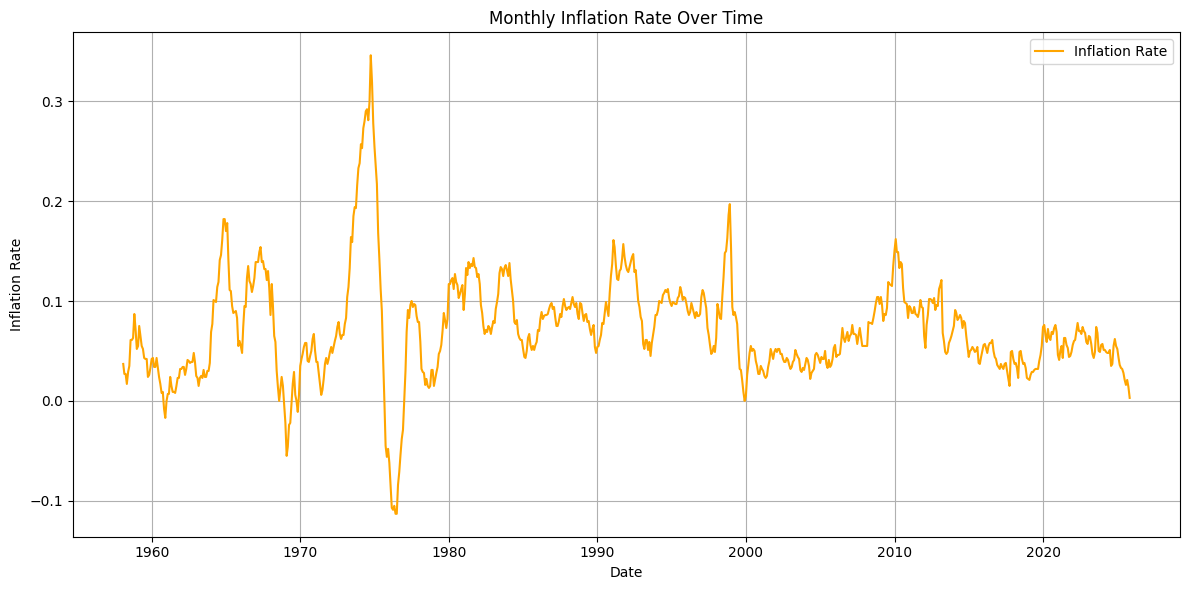

In [304]:
# Plot inflation_rate line chart
plt.figure(figsize=(12,6))
plt.plot(inflation_df.index, inflation_df['inflation_rate'], label='Inflation Rate', color='orange')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.title('Monthly Inflation Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (4) - Interest Rates

In [305]:
# Step 3: Fetch the data
series_id = 'IRSTCI01INM156N'
interest_rate_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
interest_rate_df = pd.DataFrame(interest_rate_data, columns=['Interest_Rate'])
interest_rate_df.index.name = 'Date'

interest_rate_df = interest_rate_df.resample('ME').last()

features_df_list.append(interest_rate_df)
display(interest_rate_df.tail())
# market_data = pd.merge(market_data,interest_rate_df, left_index=True, right_index=True, how='left')
# market_data.head()

,Interest_Rate
Date,
2025-06-30,5.75
2025-07-31,5.75
2025-08-31,5.75
2025-09-30,5.75
2025-10-31,5.75


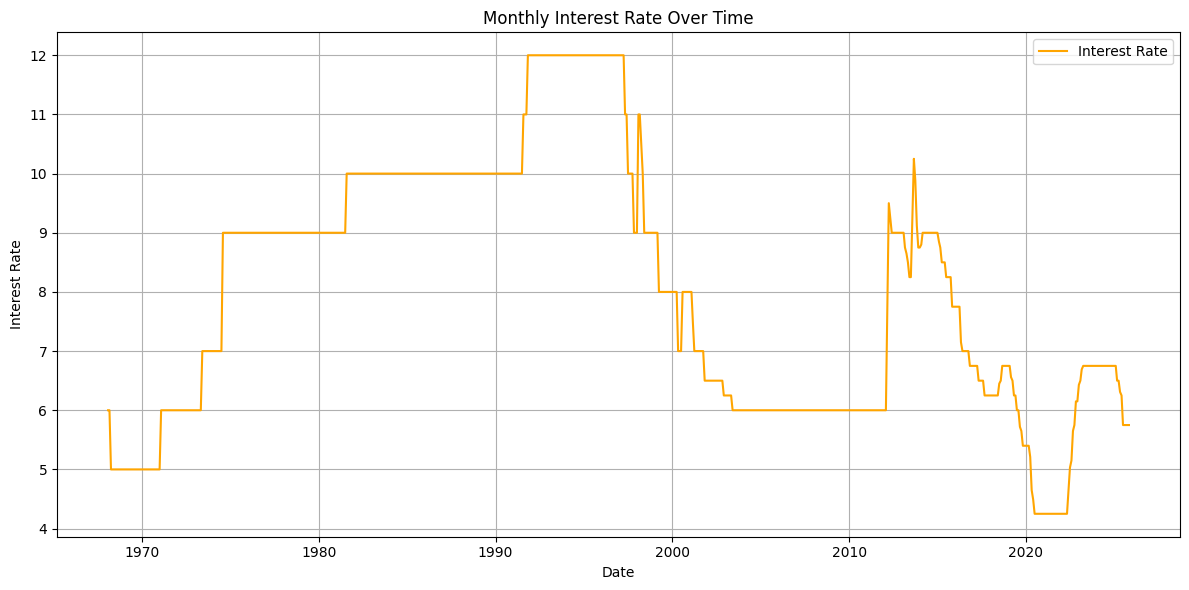

In [306]:
# Plot inflation_rate line chart
plt.figure(figsize=(12,6))
plt.plot(interest_rate_df.index, interest_rate_df['Interest_Rate'], label='Interest Rate', color='orange')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Monthly Interest Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (5) - USD / INR Exchange Rate

In [307]:
series_id = 'DEXINUS'
usd_inr_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
usd_inr_data_df = pd.DataFrame(usd_inr_data, columns=['USDINR=X'])
usd_inr_data_df.index.name = 'Date'
usd_inr_data_df = usd_inr_data_df.resample('ME').last()


ticker = 'USDINR=X'
# Download data
start_date = usd_inr_data_df.index[-1] + MonthEnd(1)
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([usd_inr_data_df,usd_inr['Close']], axis=0)
usd_inr.head()

features_df_list.append(usd_inr)
display(usd_inr.tail())
# market_data = pd.merge(market_data,usd_inr, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['USDINR=X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2026-01-31 00:00:00 -> 2025-12-15) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1769817600, endDate = 1765756800")')


,USDINR=X
Date,
2025-08-31,88.18
2025-09-30,88.78
2025-10-31,88.75
2025-11-30,89.43
2025-12-31,89.97


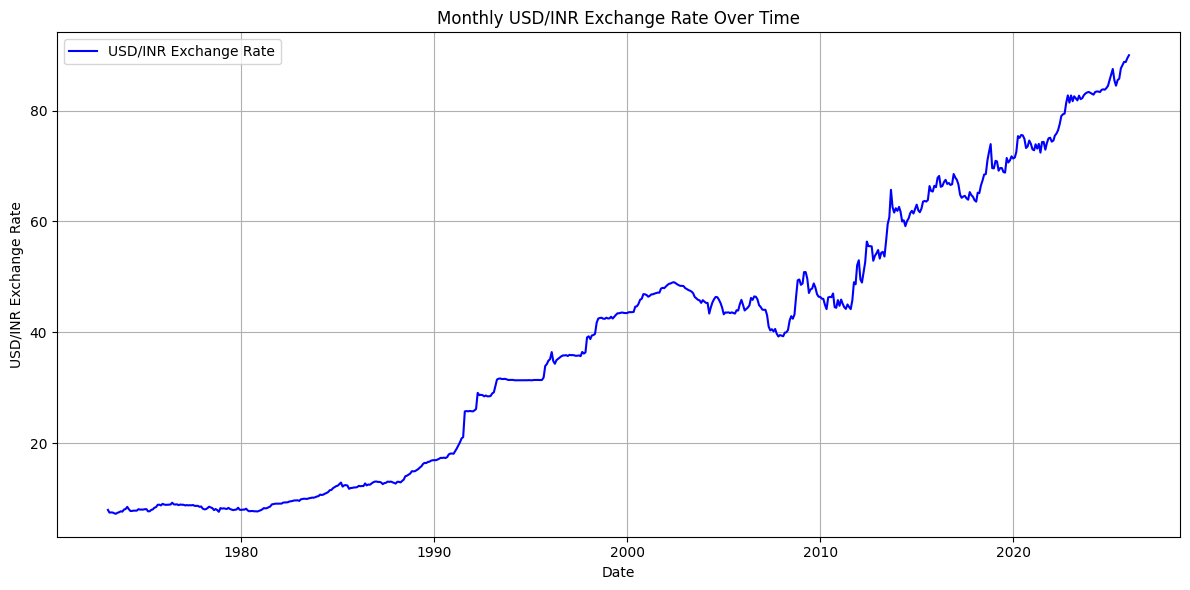

In [308]:
# Plot USDINR=X exchange rate over time
plt.figure(figsize=(12,6))
plt.plot(usd_inr.index, usd_inr['USDINR=X'], label='USD/INR Exchange Rate', color='blue')
plt.xlabel('Date')
plt.ylabel('USD/INR Exchange Rate')
plt.title('Monthly USD/INR Exchange Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (6) - Global Equity - MSCI World

In [309]:
ticker = '^990100-USD-STRD'
# Download data
start_date = market_data.index[0]
world_equity = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
world_equity = pd.DataFrame(world_equity['Close'])
world_equity.rename(columns = {'^990100-USD-STRD': 'World_Equity'}, inplace=True)
world_equity = world_equity.resample('ME').last()

features_df_list.append(world_equity)
display(world_equity.tail())
# market_data = pd.merge(market_data,world_equity, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,World_Equity
Date,
2025-08-31,4177.700195
2025-09-30,4306.700195
2025-10-31,4390.399902
2025-11-30,4398.399902
2025-12-31,4444.299805


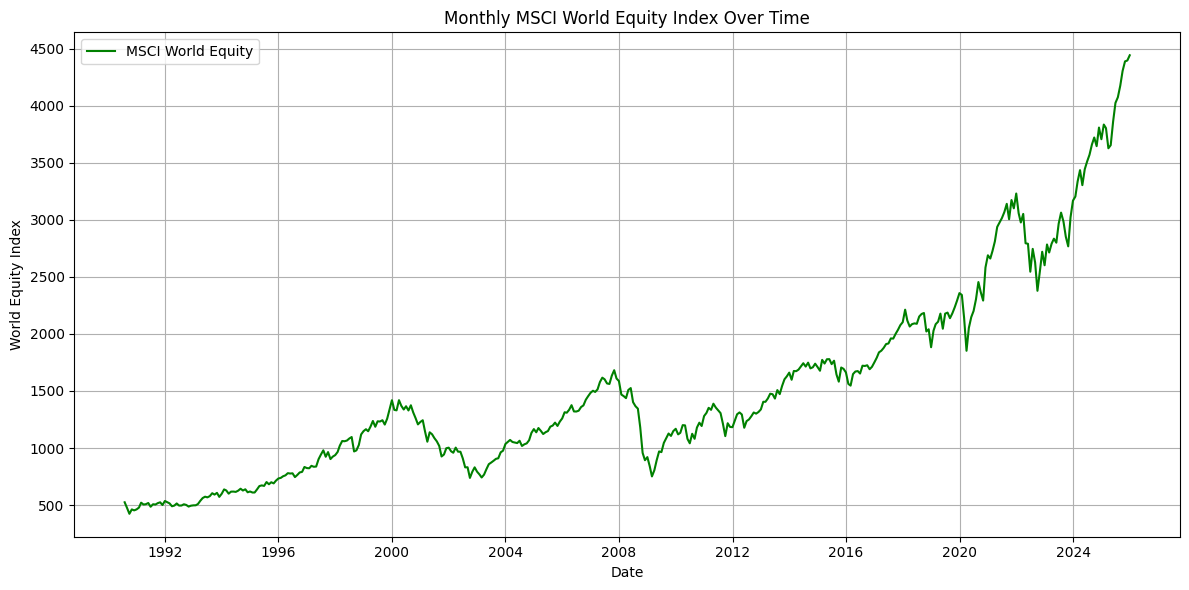

In [310]:
# Plot World_Equity over time
plt.figure(figsize=(12,6))
plt.plot(world_equity.index, world_equity['World_Equity'], label='MSCI World Equity', color='green')
plt.xlabel('Date')
plt.ylabel('World Equity Index')
plt.title('Monthly MSCI World Equity Index Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (7) - Leading Composite Index

In [311]:
import requests
import pandas as pd
from io import StringIO

# Define API query URL (example for CSV with labels format)
# This URL is an example and would need to be adapted based on your specific data selection in the OECD Data Explorer.
url = "https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CLI,/IND.M.LI...AA...H?dimensionAtObservation=AllDimensions&format=csvfilewithlabels"

# Fetch data
response = requests.get(url)
response.raise_for_status() # Raise an exception for bad status codes

# print(response.text)  # Print the first 500 characters of the response for inspection

# Read the CSV data into a pandas DataFrame
leading_composite_index_df = pd.read_csv(StringIO(response.text))
leading_composite_index_df = leading_composite_index_df[['TIME_PERIOD','OBS_VALUE']].set_index('TIME_PERIOD')
leading_composite_index_df.index = pd.to_datetime(leading_composite_index_df.index)
leading_composite_index_df = leading_composite_index_df.resample('ME').last()

# Display the first few rows of the DataFrame
display(leading_composite_index_df.tail())

features_df_list.append(leading_composite_index_df)
# market_data = pd.merge(market_data,leading_composite_index_df, left_index=True, right_index=True, how='left')
# market_data.tail()

,OBS_VALUE
TIME_PERIOD,
2025-07-31,100.4707
2025-08-31,100.5613
2025-09-30,100.6547
2025-10-31,100.7521
2025-11-30,100.8527


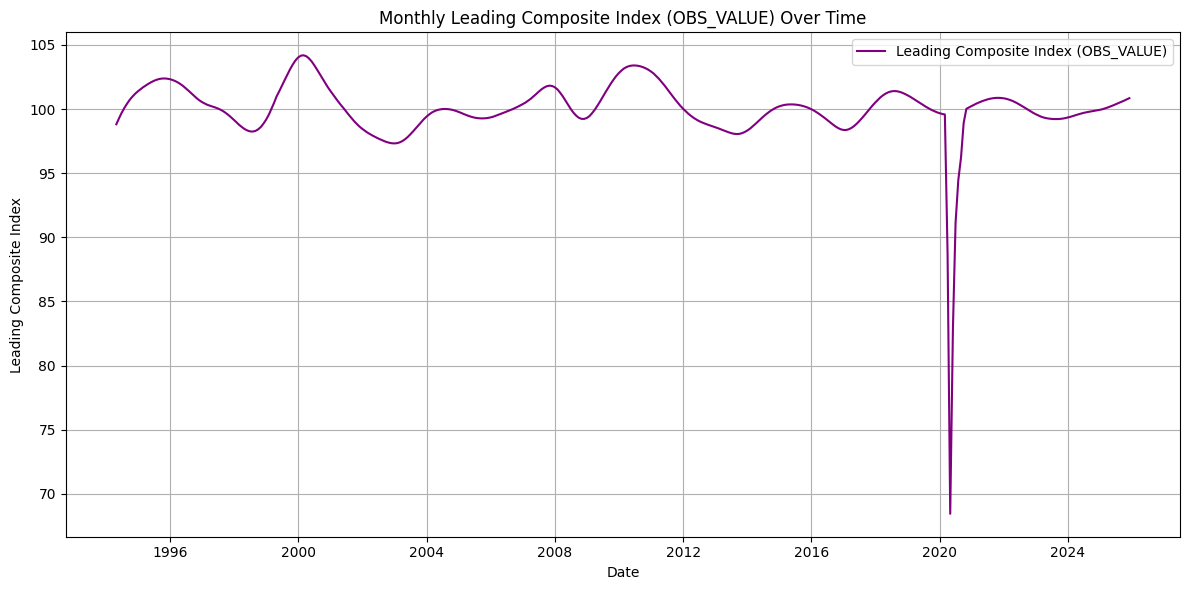

In [312]:
# Plot OBS_VALUE (Leading Composite Index) over time
plt.figure(figsize=(12,6))
plt.plot(leading_composite_index_df.index, leading_composite_index_df['OBS_VALUE'], label='Leading Composite Index (OBS_VALUE)', color='purple')
plt.xlabel('Date')
plt.ylabel('Leading Composite Index')
plt.title('Monthly Leading Composite Index (OBS_VALUE) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (8) - Nominal GDP

In [313]:
# series_id = 'NGDPNSAXDCINQ' #Nominal Gross Domestic Product for India
# gdp_data = fred.get_series(series_id)

# # Step 4: Convert to DataFrame for easier handling
# gdp_data_df = pd.DataFrame(gdp_data, columns=['GDP'])
# gdp_data_df.index.name = 'Date'
# gdp_data_df = gdp_data_df.resample('ME').last().ffill()

# features_df_list.append(gdp_data_df)
# display(gdp_data_df.tail())

# gdp_data.to_csv('data/india_gdp.csv')

gdp_data_df = pd.read_csv('data/india_gdp.csv')
gdp_data_df['Date'] = pd.to_datetime(gdp_data_df['Date'], format="%d-%m-%Y")
gdp_data_df['Date'] = pd.to_datetime(gdp_data_df['Date']) - pd.Timedelta(days=1)
gdp_data_df = gdp_data_df.set_index('Date')
gdp_data_df = gdp_data_df.resample('ME').last().ffill()

features_df_list.append(gdp_data_df[['Nominal GDP']])
display(gdp_data_df.tail(20))

,Nominal GDP
Date,
2024-03-31,79609657.0
2024-04-30,79609657.0
2024-05-31,79609657.0
2024-06-30,79078942.1
2024-07-31,79078942.1
2024-08-31,79078942.1
2024-09-30,78403450.8
2024-10-31,78403450.8
2024-11-30,78403450.8


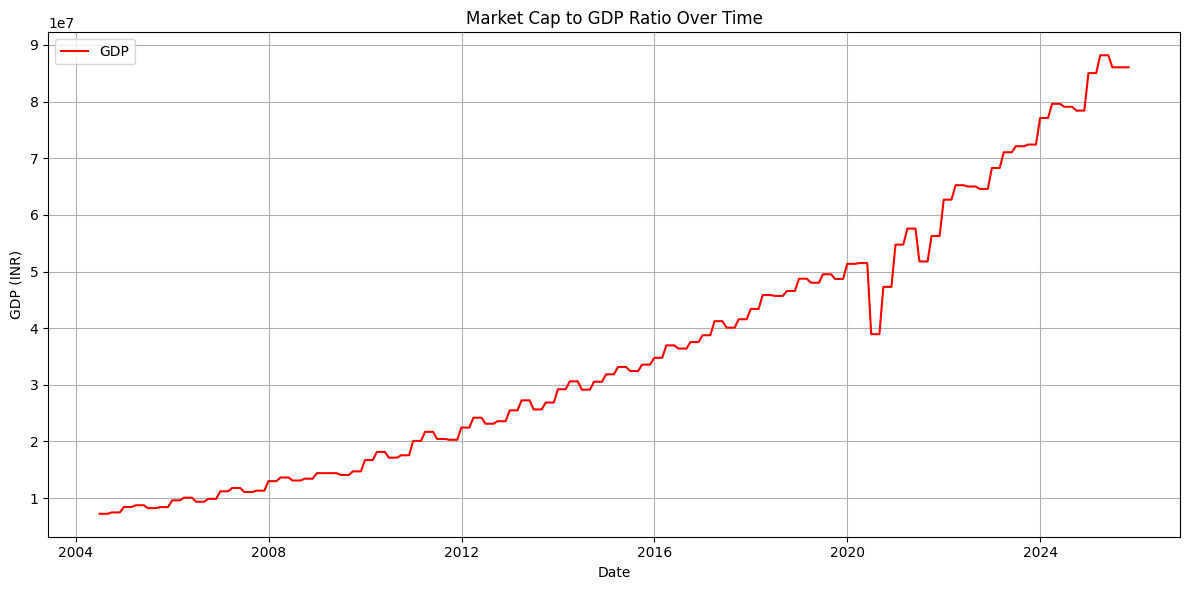

In [314]:
# Plot GDP over time
plt.figure(figsize=(12,6))
plt.plot(gdp_data_df.index, gdp_data_df['Nominal GDP'], label='GDP', color='red')
plt.xlabel('Date')
plt.ylabel('GDP (INR)')
plt.title('Market Cap to GDP Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 10. FPI Inflows

In [315]:
fpi_inflows = pd.read_excel("./data/fpi_inflows.xlsx")
fpi_inflows["Date"] = pd.to_datetime(fpi_inflows["Date"])
fpi_inflows = fpi_inflows.set_index("Date")

features_df_list.append(fpi_inflows[['FPI_Inflow']])

fpi_inflows.tail()

,FPI_Inflow
Date,
2025-06-30,-17740.58
2025-07-31,-34993.43
2025-08-31,-23884.72
2025-09-30,14610.31
2025-10-31,-3788.49


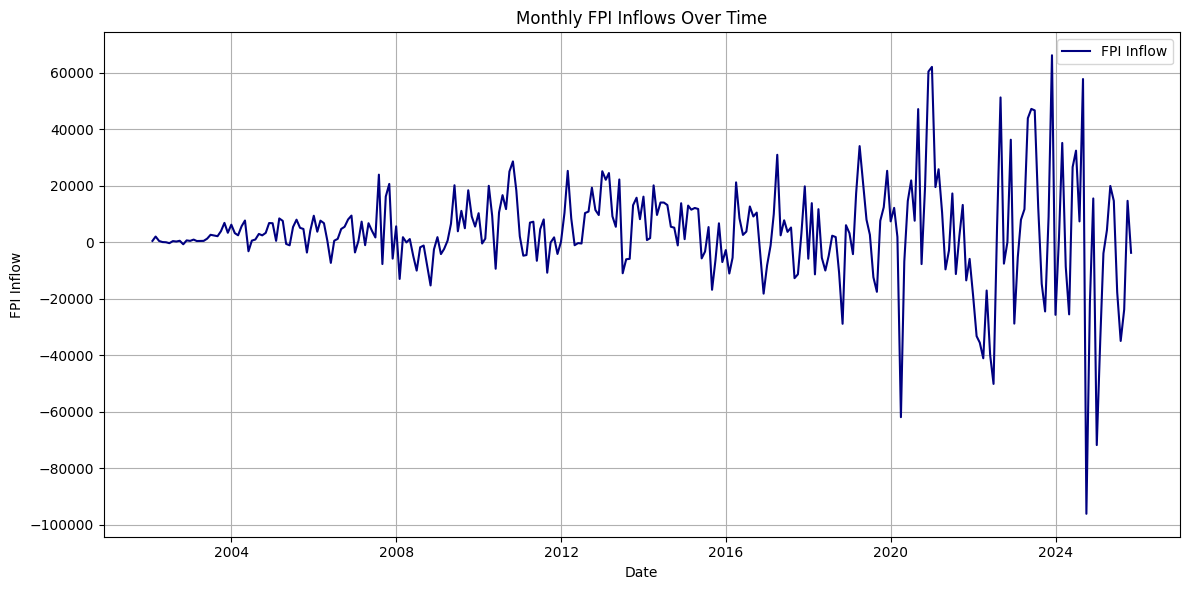

In [316]:
plt.figure(figsize=(12,6))
plt.plot(fpi_inflows.index, fpi_inflows['FPI_Inflow'], label='FPI Inflow', color='navy')
plt.xlabel('Date')
plt.ylabel('FPI Inflow')
plt.title('Monthly FPI Inflows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sentiment Features

### Adding Features (9) - Investor Sentiment (Ticker Tape)

In [317]:
# Read Market Mood Index data
market_mood_df = pd.read_csv("./data/MMI_2025-11-16.csv")

# Convert Date column to datetime with DD/MM/YYYY format
market_mood_df['Date'] = pd.to_datetime(market_mood_df['Date'], format='%d/%m/%Y')

# Set Date as index and select only Market Mood Index column
market_mood_df = market_mood_df.set_index('Date')

# Resample to month-end
market_mood_df = market_mood_df.resample('ME').last()
market_mood_df.columns = ['Market_Mood_Index', 'NIFTY']
market_mood_df = market_mood_df[['Market_Mood_Index']]

# Add to features_df_list
features_df_list.append(market_mood_df)

display(market_mood_df.tail())

,Market_Mood_Index
Date,
2025-07-31,32.641974
2025-08-31,24.846767
2025-09-30,48.485552
2025-10-31,68.686544
2025-11-30,56.910493


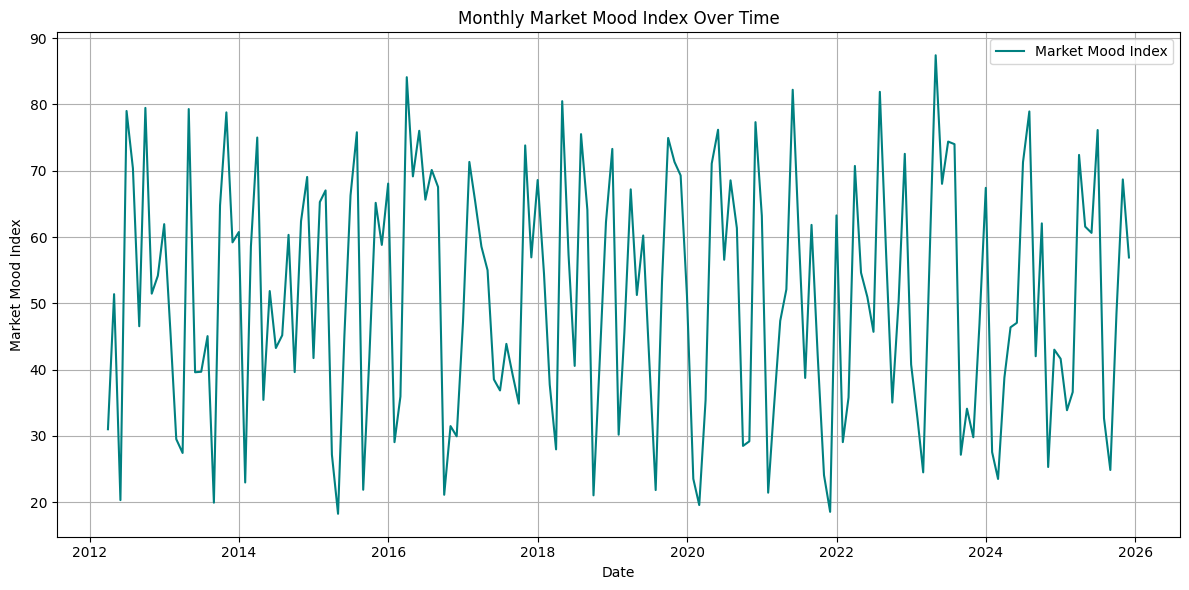

In [318]:
# Plot Market Mood Index over time
plt.figure(figsize=(12,6))
plt.plot(market_mood_df.index, market_mood_df['Market_Mood_Index'], label='Market Mood Index', color='teal')
plt.xlabel('Date')
plt.ylabel('Market Mood Index')
plt.title('Monthly Market Mood Index Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Merging dataframes and putting all features together

In [319]:
for feature_df in features_df_list:
    print(
        f"{feature_df.columns[0]}: Start Date = {feature_df.index.min().strftime('%Y-%m-%d')}, "
        f"End Date = {feature_df.index.max().strftime('%Y-%m-%d')}"
    )
    market_data = pd.merge(market_data, feature_df, left_index=True, right_index=True, how='left')



P/E: Start Date = 1995-04-30, End Date = 2025-10-31
low_risk: Start Date = 1988-11-30, End Date = 2024-12-31
momentum: Start Date = 1988-12-31, End Date = 2024-12-31
inflation_rate: Start Date = 1957-01-31, End Date = 2025-10-31
Interest_Rate: Start Date = 1968-01-31, End Date = 2025-10-31
USDINR=X: Start Date = 1973-01-31, End Date = 2025-12-31
World_Equity: Start Date = 1990-07-31, End Date = 2025-12-31
OBS_VALUE: Start Date = 1994-04-30, End Date = 2025-11-30
Nominal GDP: Start Date = 2004-03-31, End Date = 2025-10-31
FPI_Inflow: Start Date = 2002-01-31, End Date = 2025-10-31
Market_Mood_Index: Start Date = 2012-03-31, End Date = 2025-11-30


In [320]:
market_data['Nominal GDP'] = market_data['^NSEI']/market_data['Nominal GDP'] #market cap to GDP ratio

# Use pct change where needed
market_data['USDINR=X'] = market_data['USDINR=X'].pct_change()
market_data['World_Equity'] = market_data['World_Equity'].pct_change()
market_data['P/E'] = market_data['P/E'].pct_change()

market_data.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,P/E,low_risk,momentum,inflation_rate,Interest_Rate,USDINR=X,World_Equity,OBS_VALUE,Nominal GDP,FPI_Inflow,Market_Mood_Index
Date,,,,,,,,,,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN,NaN,0.009368,-0.046636,0.099,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN,NaN,-0.001512,0.076490,0.092,10.0,0.009798,-0.095574,NaN,NaN,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN,NaN,0.032534,0.067227,0.085,10.0,0.027397,-0.107572,NaN,NaN,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN,NaN,0.004055,0.039461,0.108,10.0,0.008889,0.090995,NaN,NaN,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN,NaN,-0.040276,0.046282,0.125,10.0,0.000551,-0.018414,NaN,NaN,NaN,NaN


### Create separate dataframes for macro, sentiment, and idiosyncratic

In [321]:
macro_columns = ['inflation_rate']
macro_columns_2 = ['USDINR=X', 'FPI_Inflow']
macro_columns_3 = ['World_Equity', 'Nominal GDP']
sentiment_columns = ['Market_Mood_Index']
idiosyncratic_columns = ['momentum_1_1','momentum_6_1', 'P/E']

In [322]:
market_data_macro = market_data[macro_columns + ['next_month_return']]
market_data_macro_2 = market_data[macro_columns_2 + ['next_month_return']]
market_data_macro_3 = market_data[macro_columns_3 + ['next_month_return']]
market_data_sentiment = market_data[sentiment_columns + ['next_month_return']]
market_data_idiosyncratic = market_data[idiosyncratic_columns + ['next_month_return']]

In [323]:
market_data_macro = market_data_macro["2000-01-31":]
market_data_macro = market_data_macro.dropna()
market_data_macro.tail()

,inflation_rate,next_month_return
Date,,
2025-06-30,0.021,-0.029341
2025-07-31,0.016,-0.013788
2025-08-31,0.021,0.007543
2025-09-30,0.014,0.045142
2025-10-31,0.003,0.018694


In [324]:
market_data_macro_2 = market_data_macro_2.dropna()
market_data_macro_2.tail()

,USDINR=X,FPI_Inflow,next_month_return
Date,,,
2025-06-30,0.002807,-17740.58,-0.029341
2025-07-31,0.021693,-34993.43,-0.013788
2025-08-31,0.006621,-23884.72,0.007543
2025-09-30,0.006804,14610.31,0.045142
2025-10-31,-0.000338,-3788.49,0.018694


In [325]:
market_data_macro_3 = market_data_macro_3.dropna()
market_data_macro_3.tail()

,World_Equity,Nominal GDP,next_month_return
Date,,,
2025-06-30,0.042164,0.000297,-0.029341
2025-07-31,0.012319,0.000288,-0.013788
2025-08-31,0.024951,0.000284,0.007543
2025-09-30,0.030878,0.000286,0.045142
2025-10-31,0.019435,0.000299,0.018694


In [326]:
market_data_sentiment = market_data_sentiment.dropna()
market_data_sentiment.tail()

,Market_Mood_Index,next_month_return
Date,,
2025-07-31,32.641974,-0.013788
2025-08-31,24.846767,0.007543
2025-09-30,48.485552,0.045142
2025-10-31,68.686544,0.018694
2025-11-30,56.910493,-0.011617


In [327]:
market_data_idiosyncratic = market_data_idiosyncratic.dropna()
market_data_idiosyncratic.tail()

,momentum_1_1,momentum_6_1,P/E,next_month_return
Date,,,,
2025-07-31,-0.029341,0.053596,0.022068,-0.013788
2025-08-31,-0.013788,0.104053,-0.040220,0.007543
2025-09-30,0.007543,0.046419,-0.005293,0.045142
2025-10-31,0.045142,0.057035,0.017738,0.018694
2025-11-30,0.018694,0.058675,0.000000,-0.011617


## Visualization

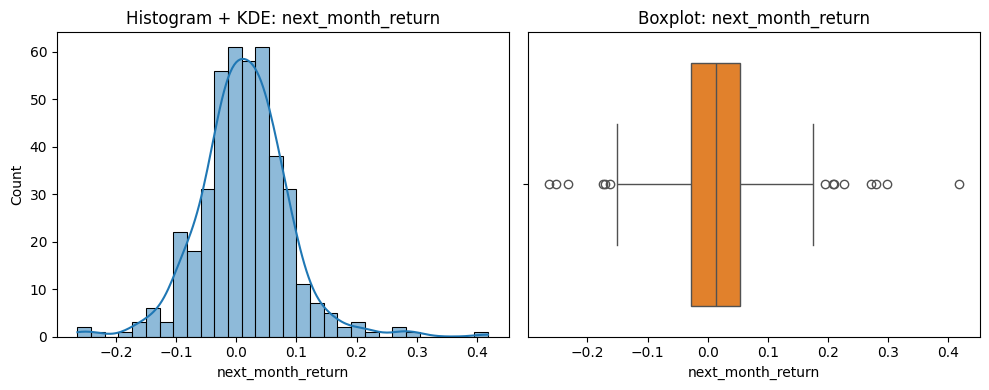

In [328]:
col = 'next_month_return'
data = market_data[col]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

# Histogram with KDE
plt.subplot(1,2,1)
sns.histplot(data, bins=30, kde=True, color='C0')
plt.title(f'Histogram + KDE: {col}')
plt.xlabel(col)
plt.ylabel('Count')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=data, color='C1')
plt.title(f'Boxplot: {col}')
plt.xlabel(col)

plt.tight_layout()
plt.show()

## Pre-Processing 

In [329]:
return_threshold = market_data_macro['next_month_return'].quantile(0.25)
return_threshold

np.float64(-0.022712435930456937)

In [330]:
# Create the 'positive_returns' column

bins = [-np.inf,return_threshold, np.inf]
labels = [0, 1]

market_data_macro['regime'] = pd.cut(
    market_data_macro['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_macro_2['regime'] = pd.cut(
    market_data_macro_2['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_macro_3['regime'] = pd.cut(
    market_data_macro_3['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_sentiment['regime'] = pd.cut(
    market_data_sentiment['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_idiosyncratic['regime'] = pd.cut(
    market_data_idiosyncratic['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

## Random Forest Classifiers

We will create three random forest classifiers - macro, sentiment, and idiosyncratic. Then we will combine the outputs of these three classifiers to get the final regime classification  output

### Macro Classifier

In [331]:
from itertools import combinations

train_test_split = 0.80

# assume z_score_columns already exists
# feature_pairs = list(combinations(z_score_columns, 1))            # list of tuples

split_of_date_to_use = round(train_test_split*len(market_data_macro))
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro[macro_columns].iloc[:split_of_date_to_use]
y = market_data_macro['regime'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf_macro = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro = cross_val_score(clf_macro, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro.fit(X, y)

print("Training from date {} to {}".format(X.index[0].date(), X.index[-1].date()))

# Output results
print(f"Cross-Validation Scores: {cv_scores_macro}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro):.4f}")

last_training_date = X.index[-1].date()

Training from date 2000-01-31 to 2020-08-31
Cross-Validation Scores: [0.66       0.64       0.42       0.67346939 0.57142857]
Mean Accuracy: 0.5930
Standard Deviation: 0.0933


### Macro Classifier 2

In [332]:
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro_2[macro_columns_2].loc[:last_training_date]
y = market_data_macro_2['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_macro_2 = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro_2 = cross_val_score(clf_macro_2, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro_2.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_macro_2}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro_2):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro_2):.4f}")

Trainign from date 2002-01-31 to 2020-08-31
Cross-Validation Scores: [0.62222222 0.64444444 0.57777778 0.66666667 0.56818182]
Mean Accuracy: 0.6159
Standard Deviation: 0.0378


### Macro Classifer 3

In [333]:
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro_3[macro_columns_3].loc[:last_training_date]
y = market_data_macro_3['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_macro_3 = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro_3 = cross_val_score(clf_macro_3, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro_3.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_macro_3}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro_3):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro_3):.4f}")

Trainign from date 2004-06-30 to 2020-08-31
Cross-Validation Scores: [0.56410256 0.56410256 0.64102564 0.66666667 0.74358974]
Mean Accuracy: 0.6359
Standard Deviation: 0.0676


### Sentiment Classifier

In [334]:
X = market_data_sentiment[sentiment_columns].loc[:last_training_date]
y = market_data_sentiment['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_sentiment = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_sentiment = cross_val_score(clf_sentiment, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_sentiment.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_sentiment}")
print(f"Mean Accuracy: {np.mean(cv_scores_sentiment):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_sentiment):.4f}")

Trainign from date 2012-03-31 to 2020-08-31
Cross-Validation Scores: [0.61904762 0.57142857 0.65       0.6        0.6       ]
Mean Accuracy: 0.6081
Standard Deviation: 0.0259


### Technical Classifier

In [335]:
X = market_data_idiosyncratic[idiosyncratic_columns].loc[:last_training_date]
y = market_data_idiosyncratic['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_idiosyncratic = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_idiosyncratic = cross_val_score(clf_idiosyncratic, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_idiosyncratic.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_idiosyncratic}")
print(f"Mean Accuracy: {np.mean(cv_scores_idiosyncratic):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_idiosyncratic):.4f}")

Trainign from date 2000-02-29 to 2020-08-31
Cross-Validation Scores: [0.6        0.56       0.67346939 0.65306122 0.63265306]
Mean Accuracy: 0.6238
Standard Deviation: 0.0401


## Combining output on Test Data

In [336]:
X = market_data_macro[macro_columns].iloc[split_of_date_to_use:]
y_macro = market_data_macro['regime'].iloc[split_of_date_to_use:]
macro_classifier_output = clf_macro.predict(X)

X = market_data_macro_2[macro_columns_2].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_macro_2['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
macro_classifier_output_2 = clf_macro_2.predict(X)

X = market_data_macro_3[macro_columns_3].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_macro_3['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
macro_classifier_output_3 = clf_macro_3.predict(X)

X = market_data_sentiment[sentiment_columns].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_sentiment['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
sentiment_classifier_output = clf_sentiment.predict(X)

X = market_data_idiosyncratic[idiosyncratic_columns].loc[y_macro.index[0]:y_macro.index[-1]]
y_idiosyncratic = market_data_idiosyncratic['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
idiosyncratic_classifier_output = clf_idiosyncratic.predict(X)

print("Prediction From {} to {}".format(y_macro.index[0].strftime('%Y-%m-%d'), y_macro.index[-1].strftime('%Y-%m-%d')))

Prediction From 2020-09-30 to 2025-10-31


In [337]:
print("Length of macro_classifier_output:", len(macro_classifier_output))
print("Length of macro_classifier_output_2:", len(macro_classifier_output_2))
print("Length of macro_classifier_output_3:", len(macro_classifier_output_3))
print("Length of sentiment_classifier_output:", len(sentiment_classifier_output))
print("Length of idiosyncratic_classifier_output:", len(idiosyncratic_classifier_output))

test_output_df = pd.DataFrame({
    'Actual_Regime': y_macro,
    'Macro_Predicted_Regime': macro_classifier_output,
    'Macro Predicted_Regime 2': macro_classifier_output_2,
    'Macro Predicted_Regime 3': macro_classifier_output_3,
    'Sentiment_Predicted_Regime': sentiment_classifier_output,
    'Idiosyncratic_Predicted_Regime': idiosyncratic_classifier_output
})

test_output_df['Predicted_Regime'] = test_output_df[['Macro Predicted_Regime 2','Macro Predicted_Regime 3','Sentiment_Predicted_Regime', 'Idiosyncratic_Predicted_Regime']].mode(axis=1)[0]

test_output_df.tail()

Length of macro_classifier_output: 62
Length of macro_classifier_output_2: 62
Length of macro_classifier_output_3: 62
Length of sentiment_classifier_output: 62
Length of idiosyncratic_classifier_output: 62


,Actual_Regime,Macro_Predicted_Regime,Macro Predicted_Regime 2,Macro Predicted_Regime 3,Sentiment_Predicted_Regime,Idiosyncratic_Predicted_Regime,Predicted_Regime
Date,,,,,,,
2025-06-30,0,1,1,1,1,0,1.0
2025-07-31,1,1,1,1,0,1,1.0
2025-08-31,1,1,1,1,0,1,1.0
2025-09-30,1,1,1,1,1,1,1.0
2025-10-31,1,1,1,1,1,1,1.0


In [338]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(test_output_df["Actual_Regime"], test_output_df["Predicted_Regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_output_df["Actual_Regime"], test_output_df["Predicted_Regime"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            4            9
Actual 1            3           46
Accuracy: 80.65%


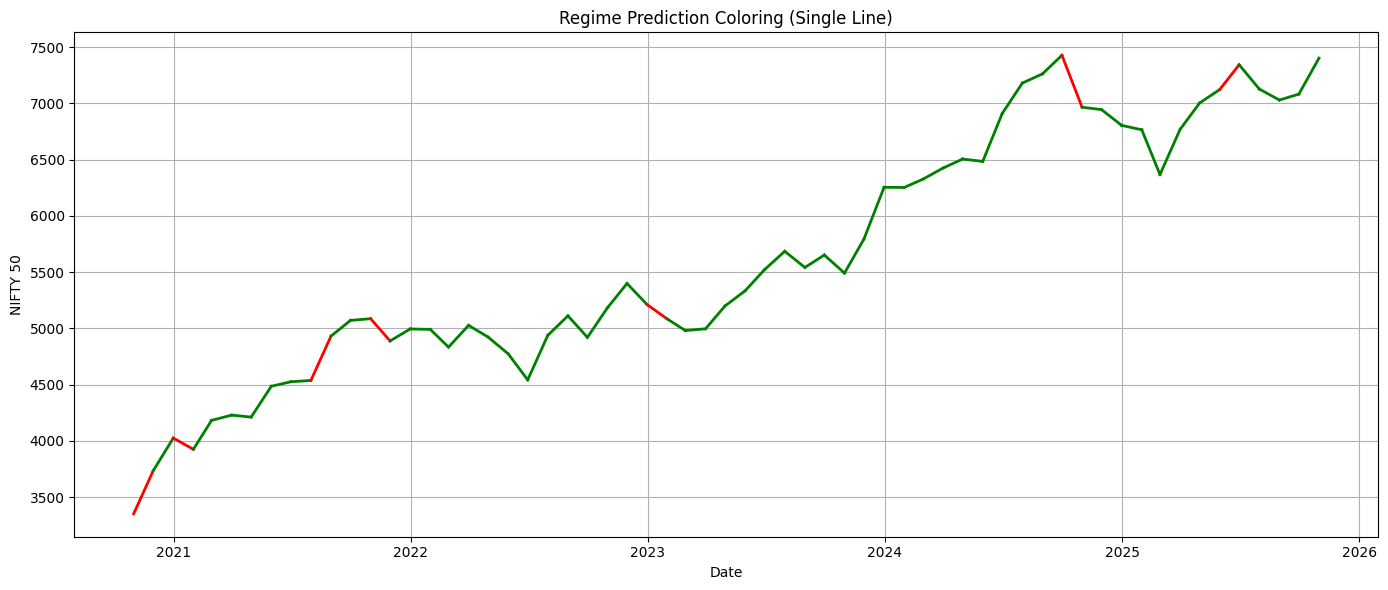

In [339]:
# Merge Portfolio and Predicted_Regime, shift regime by 1 month
portfolio_regime_df = pd.DataFrame({
    "Portfolio": market_data["Portfolio"]
}).merge(
    test_output_df[["Predicted_Regime"]].shift(1), 
    left_index=True, right_index=True, how="left"
)

portfolio_regime_df = portfolio_regime_df.dropna()

# Plot a single line, colored by regime
plt.figure(figsize=(14,6))
colors = {0: "red", 1: "green"}
regimes = portfolio_regime_df["Predicted_Regime"].values
portfolio = portfolio_regime_df["Portfolio"].values
dates = portfolio_regime_df.index

for i in range(1, len(portfolio)):
    plt.plot(dates[i-1:i+1], portfolio[i-1:i+1], color=colors[regimes[i]], linewidth=2)

plt.xlabel("Date")
plt.ylabel("NIFTY 50")
plt.title("Regime Prediction Coloring (Single Line)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Bayesian Network - Hidden Markov Model

In [387]:
print("\nStep 4.2.2: Hidden Markov Model Training (Categorical-HMM)")

from hmmlearn import hmm
import numpy as np

print("\nPreparing data for HMM training...")

# Compute log returns
# returns = np.log(market_data["^NSEI"] / market_data["^NSEI"].shift(1)).dropna()
returns = market_data["Return"].dropna()
X_cont = returns.values  # continuous returns (for quantile binning)

print(f"Log returns calculated: {len(returns)} data points")
print(f"Data shape: {X_cont.shape}")

# Categorize into 3 regimes using quantiles
# q1, q2 = returns.quantile([0.33, 0.66])

q1, q2 = -0.005, 0.005

def categorize(r):
    if r <= q1:
        return 0  # Bear
    elif r <= q2:
        return 1  # Stagnant
    return 2      # Bull

regimes = np.array([categorize(r) for r in X_cont])

# Categorical needs shape [n_samples, 1]
X = regimes.reshape(-1, 1)

print("\nRegime thresholds:")
print(f"  Bear: <= {q1:.6f}")
print(f"  Stagnant: <= {q2:.6f}")
print(f"  Bull: > {q2:.6f}")
print(f"Samples in each regime: {np.bincount(regimes)}")

# Initialize Categorical HMM (3 regimes)
model = hmm.CategoricalHMM(
    n_components=3,
    n_iter=100,
    random_state=42,
    init_params="ste",
    verbose=False
)


print("\nTraining HMM using Baum-Welch algorithm...")
try:
    model.fit(X)
    print("✓ HMM training completed")
    print(f"  Converged in {model.monitor_.iter} iterations")
    print(f"  Final log-likelihood: {model.score(X):.3f}")

except Exception as e:
    print(f"❌ Training failed: {e}")



Step 4.2.2: Hidden Markov Model Training (Categorical-HMM)

Preparing data for HMM training...
Log returns calculated: 425 data points
Data shape: (425,)

Regime thresholds:
  Bear: <= -0.005000
  Stagnant: <= 0.005000
  Bull: > 0.005000
Samples in each regime: [166  29 230]

Training HMM using Baum-Welch algorithm...
✓ HMM training completed
  Converged in 63 iterations
  Final log-likelihood: -369.080


In [388]:
# Display the learned HMM parameters
print("\n" + "="*50)
print("LEARNED CATEGORICAL HMM PARAMETERS")
print("="*50)

hidden_states = model.predict(X)

# 1️⃣ Emission probabilities
print("\n1. EMISSION PROBABILITIES (what each regime emits):")
print("   Rows = Hidden states, Columns = Observed return category (0=Bear,1=Stagnant,2=Bull)")
for i, probs in enumerate(model.emissionprob_):
    print(f"   State {i}: {probs}")

# Interpret regime based on most likely emission
# state_labels = np.argmax(model.emissionprob_, axis=1)
# print(state_labels)
# label_map = {0: "Bear", 1: "Stagnant", 2: "Bull"}
# state_names = [label_map[l] for l in state_labels]
state_names = ["Bear", "Stagnant", "Bull"]

# print("\n   Regime meaning based on emissions:")
# for i, name in enumerate(state_names):
#     print(f"   State {i}: {name}")

# 2️⃣ Transition Matrix
print("\n2. TRANSITION MATRIX (probability of regime switching):")
print("   Rows = From State, Columns = To State")
print(model.transmat_)

# Persistence & Expected Duration
print("\n   Expected duration in each state:")
for i in range(model.n_components):
    p = model.transmat_[i, i]
    duration = 1 / (1 - p) if p < 1 else float("inf")
    print(f"   State {i} ({state_names[i]}): {duration:.2f} periods")

# 3️⃣ Start probabilities
print("\n3. START PROBABILITIES:")
for i, p in enumerate(model.startprob_):
    print(f"   State {i}: {p:.4f}")

# 4️⃣ State-conditional return statistics
print("\n4. STATE-CONDITIONAL RETURN STATISTICS:")
for state in range(model.n_components):
    idx = hidden_states == state
    count = np.sum(idx)
    state_ret = returns[idx]

    print(f"\n   State {state} ({state_names[state]}):")
    print(f"     - Frequency: {count} samples ({count/len(returns)*100:.1f}%)")
    print(f"     - Mean return: {state_ret.mean():.6f}")
    print(f"     - Std dev: {state_ret.std():.6f}")

# 5️⃣ Model Quality Assessment
logL = model.score(X)
print("\n5. MODEL QUALITY:")
print(f"   Log Likelihood: {logL:.4f}")

# Parameter count for Categorical HMM
n_states = model.n_components
n_observations = len(np.unique(X))  # 3 categories

n_params = (
    (n_states - 1) +                          # startprob params
    n_states * (n_states - 1) +               # transition params
    n_states * (n_observations - 1)           # emission params
)

AIC = -2 * logL + 2 * n_params
BIC = -2 * logL + np.log(len(X)) * n_params

print(f"   Num. parameters: {n_params}")
print(f"   AIC: {AIC:.4f}")
print(f"   BIC: {BIC:.4f}")

# 6️⃣ Save the trained model
print("\n6. SAVING MODEL:")
import joblib
joblib.dump(model, "categorical_hmm_model.pkl")
print("   ✓ Saved as categorical_hmm_model.pkl")

print("\n" + "="*50)
print("CATEGORICAL HMM TRAINING COMPLETE")
print("="*50)



LEARNED CATEGORICAL HMM PARAMETERS

1. EMISSION PROBABILITIES (what each regime emits):
   Rows = Hidden states, Columns = Observed return category (0=Bear,1=Stagnant,2=Bull)
   State 0: [0.46580075 0.01017049 0.52402877]
   State 1: [5.37417085e-01 3.08169975e-05 4.62552098e-01]
   State 2: [0.23815835 0.15464441 0.60719724]

2. TRANSITION MATRIX (probability of regime switching):
   Rows = From State, Columns = To State
[[3.99705698e-04 9.99489709e-01 1.10585121e-04]
 [8.59169181e-01 4.49633458e-03 1.36334484e-01]
 [7.59240226e-02 1.69883074e-02 9.07087670e-01]]

   Expected duration in each state:
   State 0 (Bear): 1.00 periods
   State 1 (Stagnant): 1.00 periods
   State 2 (Bull): 10.76 periods

3. START PROBABILITIES:
   State 0: 1.0000
   State 1: 0.0000
   State 2: 0.0000

4. STATE-CONDITIONAL RETURN STATISTICS:

   State 0 (Bear):
     - Frequency: 133 samples (31.3%)
     - Mean return: 0.016689
     - Std dev: 0.077198

   State 1 (Stagnant):
     - Frequency: 132 samples (

In [389]:
print("\nStep 4.2.3: Regime Detection using Viterbi Algorithm")

print("Applying Viterbi algorithm to find the most likely sequence of hidden states...")

# Use the trained HMM to predict the most likely sequence of hidden states
print("Running Viterbi algorithm...")
hidden_states = model.predict(X)

print("✓ Viterbi algorithm completed successfully")
print(f"Most likely sequence: {len(hidden_states)} hidden states")

price_column = "^NSEI"
price_series = market_data[price_column]

# Create a comprehensive dataframe with regimes and associated data
print("\nCreating regime analysis dataframe...")
price_with_regimes = pd.DataFrame({
    price_column: price_series.iloc[1:].values,  # Skip first due to returns calculation
    'Returns': returns.values,
    'Price_Diff': price_series.diff().iloc[1:].values,
    'Regime_Raw': hidden_states  # Raw state assignments before interpretation
}, index=price_series.index[1:])  # Align index with returns (skip first observation)

print(f"Regime dataframe created: {price_with_regimes.shape}")
print(f"Date range: {price_with_regimes.index.min()} to {price_with_regimes.index.max()}")

# Display initial regime distribution
print("\nInitial Regime Distribution (Raw States):")
regime_counts_raw = pd.Series(hidden_states).value_counts().sort_index()
for regime, count in regime_counts_raw.items():
    percentage = count / len(hidden_states) * 100
    mean_return = price_with_regimes[price_with_regimes['Regime_Raw'] == regime]['Returns'].mean()
    print(f"  State {regime}: {count} observations ({percentage:.1f}%), mean return: {mean_return:.6f}")

# Calculate mean returns for each raw state to interpret them
print("\nCalculating state interpretations based on mean returns...")
regime_means = price_with_regimes.groupby('Regime_Raw')['Returns'].mean()
print("Mean returns by raw state:")
for regime, mean_return in regime_means.items():
    print(f"  State {regime}: {mean_return:.6f} (annualized: {mean_return*12*100:.2f}%)")

# Map raw states to meaningful labels based on economic interpretation
# States are sorted by their mean returns: lowest = Bear, middle = Stagnant, highest = Bull
print("\nMapping raw states to economic regimes...")
sorted_regimes = regime_means.sort_values().index.tolist()
regime_mapping = {
    sorted_regimes[0]: 0,  # Bear market (lowest returns)
    sorted_regimes[1]: 1,  # Stagnant market (middle returns)
    sorted_regimes[2]: 2   # Bull market (highest returns)
}

print(f"Raw state mapping: {regime_mapping}")
print("Interpretation:")
for raw_state, mapped_state in regime_mapping.items():
    mean_return = regime_means[raw_state]
    label = {0: 'Bear', 1: 'Stagnant', 2: 'Bull'}[mapped_state]
    print(f"  Raw State {raw_state} → {label} (mean return: {mean_return:.6f})")

# Apply the mapping to create meaningful regime labels
price_with_regimes['Regime'] = price_with_regimes['Regime_Raw'].map(regime_mapping)

# Verify the mapping worked correctly
print("\nVerifying regime mapping...")
final_means = price_with_regimes.groupby('Regime')['Returns'].mean()
regime_labels = {0: 'Bear', 1: 'Stagnant', 2: 'Bull'}

print("Final Regime Distribution:")
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    count = len(regime_data)
    percentage = count / len(price_with_regimes) * 100
    mean_return = final_means[regime]
    std_return = regime_data['Returns'].std()

    print(f"  {regime_labels[regime]} Market (State {regime}):")
    print(f"    - Observations: {count} ({percentage:.1f}%)")
    print(f"    - Mean return: {mean_return:.6f}")
    print(f"    - Return volatility: {std_return:.6f}")
    if std_return > 0:
        sharpe = mean_return / std_return
        print(f"    - Sharpe ratio: {sharpe:.4f}")

# Analyze regime transitions and persistence
print("\nAnalyzing regime transitions...")

# Calculate regime durations and transitions
regime_changes = (price_with_regimes['Regime'] != price_with_regimes['Regime'].shift(1))
regime_periods = regime_changes.cumsum()

# Calculate duration statistics for each regime
print("Regime Duration Analysis:")
duration_stats = []
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    regime_periods_subset = regime_periods[price_with_regimes['Regime'] == regime]

    period_lengths = regime_periods_subset.value_counts().values

    if len(period_lengths) > 0:
        avg_duration = period_lengths.mean()
        max_duration = period_lengths.max()
        min_duration = period_lengths.min()
        num_periods = len(period_lengths)

        print(f"  {regime_labels[regime]} Market:")
        print(f"    - Number of periods: {num_periods}")
        print(f"    - Average duration: {avg_duration:.1f} months")
        print(f"    - Longest period: {max_duration} months")
        print(f"    - Shortest period: {min_duration} months")

        duration_stats.append({
            'Regime': regime_labels[regime],
            'Num_Periods': num_periods,
            'Avg_Duration': avg_duration,
            'Max_Duration': max_duration,
            'Min_Duration': min_duration
        })

# Calculate empirical transition probabilities
print("\nEmpirical Transition Probabilities:")
transition_counts = np.zeros((3, 3))

for i in range(1, len(price_with_regimes)):
    from_state = price_with_regimes['Regime'].iloc[i-1]
    to_state = price_with_regimes['Regime'].iloc[i]
    transition_counts[from_state, to_state] += 1

# Convert counts to probabilities
transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

print("   From\\To    Bear   Stagnant   Bull")
print("   " + "-" * 35)
for i in range(3):
    row = [f"{transition_probs[i, j]:8.3f}" for j in range(3)]
    print(f"   {regime_labels[i]:<8} {' '.join(row)}")

# Compare with model's learned transition probabilities
print("\nComparison with Model's Learned Transition Probabilities:")
print("   From\\To    Bear   Stagnant   Bull")
print("   " + "-" * 35)
for i in range(3):
    learned_row = [f"{model.transmat_[i, j]:8.3f}" for j in range(3)]
    print(f"   {regime_labels[i]:<8} {' '.join(learned_row)}")

# Identify major regime periods
print("\nIdentifying Major Regime Periods...")
major_periods = []

current_regime = price_with_regimes['Regime'].iloc[0]
start_date = price_with_regimes.index[0]
duration = 1

for i in range(1, len(price_with_regimes)):
    if price_with_regimes['Regime'].iloc[i] == current_regime:
        duration += 1
    else:
        # End of current regime period
        end_date = price_with_regimes.index[i-1]
        major_periods.append({
            'Regime': regime_labels[current_regime],
            'Start_Date': start_date,
            'End_Date': end_date,
            'Duration': duration,
            'Total_Return': (price_with_regimes[price_column].iloc[i-1] / price_with_regimes[price_column].iloc[i-duration] - 1) * 100
        })

        # Start new regime period
        current_regime = price_with_regimes['Regime'].iloc[i]
        start_date = price_with_regimes.index[i]
        duration = 1

# Add the last period
end_date = price_with_regimes.index[-1]
major_periods.append({
    'Regime': regime_labels[current_regime],
    'Start_Date': start_date,
    'End_Date': end_date,
    'Duration': duration,
    'Total_Return': (price_with_regimes[price_column].iloc[-1] / price_with_regimes[price_column].iloc[-duration] - 1) * 100
})

# Display the longest regime periods
print("\nLongest Regime Periods:")
major_periods_sorted = sorted(major_periods, key=lambda x: x['Duration'], reverse=True)[:5]

for i, period in enumerate(major_periods_sorted, 1):
    print(f"  {i}. {period['Regime']} Market:")
    print(f"     Duration: {period['Duration']} months")
    print(f"     Period: {period['Start_Date'].strftime('%Y-%m')} to {period['End_Date'].strftime('%Y-%m')}")
    print(f"     Total Return: {period['Total_Return']:.1f}%")

# Save the regime analysis results
print("\nSaving regime detection results...")
regime_data_path = 'regime_detection_results.csv'
price_with_regimes.to_csv(regime_data_path)
print(f"✓ Regime data saved to: {regime_data_path}")

# Save regime mapping for future use
regime_mapping_path = 'regime_mapping.npy'
np.save(regime_mapping_path, regime_mapping)
print(f"✓ Regime mapping saved to: {regime_mapping_path}")

# Save major periods analysis
import json
major_periods_path = 'major_regime_periods.json'
with open(major_periods_path, 'w') as f:
    # Convert dates to strings for JSON serialization
    periods_serializable = []
    for period in major_periods:
        periods_serializable.append({
            'Regime': period['Regime'],
            'Start_Date': period['Start_Date'].strftime('%Y-%m-%d'),
            'End_Date': period['End_Date'].strftime('%Y-%m-%d'),
            'Duration': period['Duration'],
            'Total_Return': period['Total_Return']
        })
    json.dump(periods_serializable, f, indent=2)
print(f"✓ Major regime periods saved to: {major_periods_path}")

print("\n" + "="*60)
print("VITERBI ALGORITHM COMPLETE")
print("="*60)
print("✓ Most likely state sequence identified")
print("✓ Raw states mapped to economic regimes (Bear/Stagnant/Bull)")
print("✓ Regime transition analysis completed")
print("✓ Major regime periods identified")
print("✓ All results saved for future analysis")
print("✓ Next: Create regime visualizations and statistical analysis")
print("="*60)

# Display final summary
print("\nFINAL REGIME DETECTION SUMMARY:")
print(f"Total periods analyzed: {len(price_with_regimes)}")
for regime in [0, 1, 2]:
    count = (price_with_regimes['Regime'] == regime).sum()
    percentage = count / len(price_with_regimes) * 100
    print(f"  {regime_labels[regime]}: {count} periods ({percentage:.1f}%)")

print(f"\nRegime data available in: price_with_regimes DataFrame")
print(f"Use this for subsequent Bayesian Network training")


Step 4.2.3: Regime Detection using Viterbi Algorithm
Applying Viterbi algorithm to find the most likely sequence of hidden states...
Running Viterbi algorithm...
✓ Viterbi algorithm completed successfully
Most likely sequence: 425 hidden states

Creating regime analysis dataframe...
Regime dataframe created: (425, 4)
Date range: 1990-08-31 00:00:00 to 2025-12-31 00:00:00

Initial Regime Distribution (Raw States):
  State 0: 133 observations (31.3%), mean return: 0.016689
  State 1: 132 observations (31.1%), mean return: 0.001146
  State 2: 160 observations (37.6%), mean return: 0.019416

Calculating state interpretations based on mean returns...
Mean returns by raw state:
  State 0: 0.016689 (annualized: 20.03%)
  State 1: 0.001146 (annualized: 1.38%)
  State 2: 0.019416 (annualized: 23.30%)

Mapping raw states to economic regimes...
Raw state mapping: {1: 0, 0: 1, 2: 2}
Interpretation:
  Raw State 1 → Bear (mean return: 0.001146)
  Raw State 0 → Stagnant (mean return: 0.016689)
  Raw


Step 4.2.4: Interpreting and Mapping Regimes
Mean price changes by regime:
  State 0: -6.4021
  State 1: 50.5728
  State 2: 122.9375
Regime mapping: {0: 0, 1: 1, 2: 2}

Final regime interpretation:
  Bear (State 0): 132 observations, mean change: -6.4021
  Stagnant (State 1): 133 observations, mean change: 50.5728
  Bull (State 2): 160 observations, mean change: 122.9375

Step 4.2.5: Creating Regime Visualization


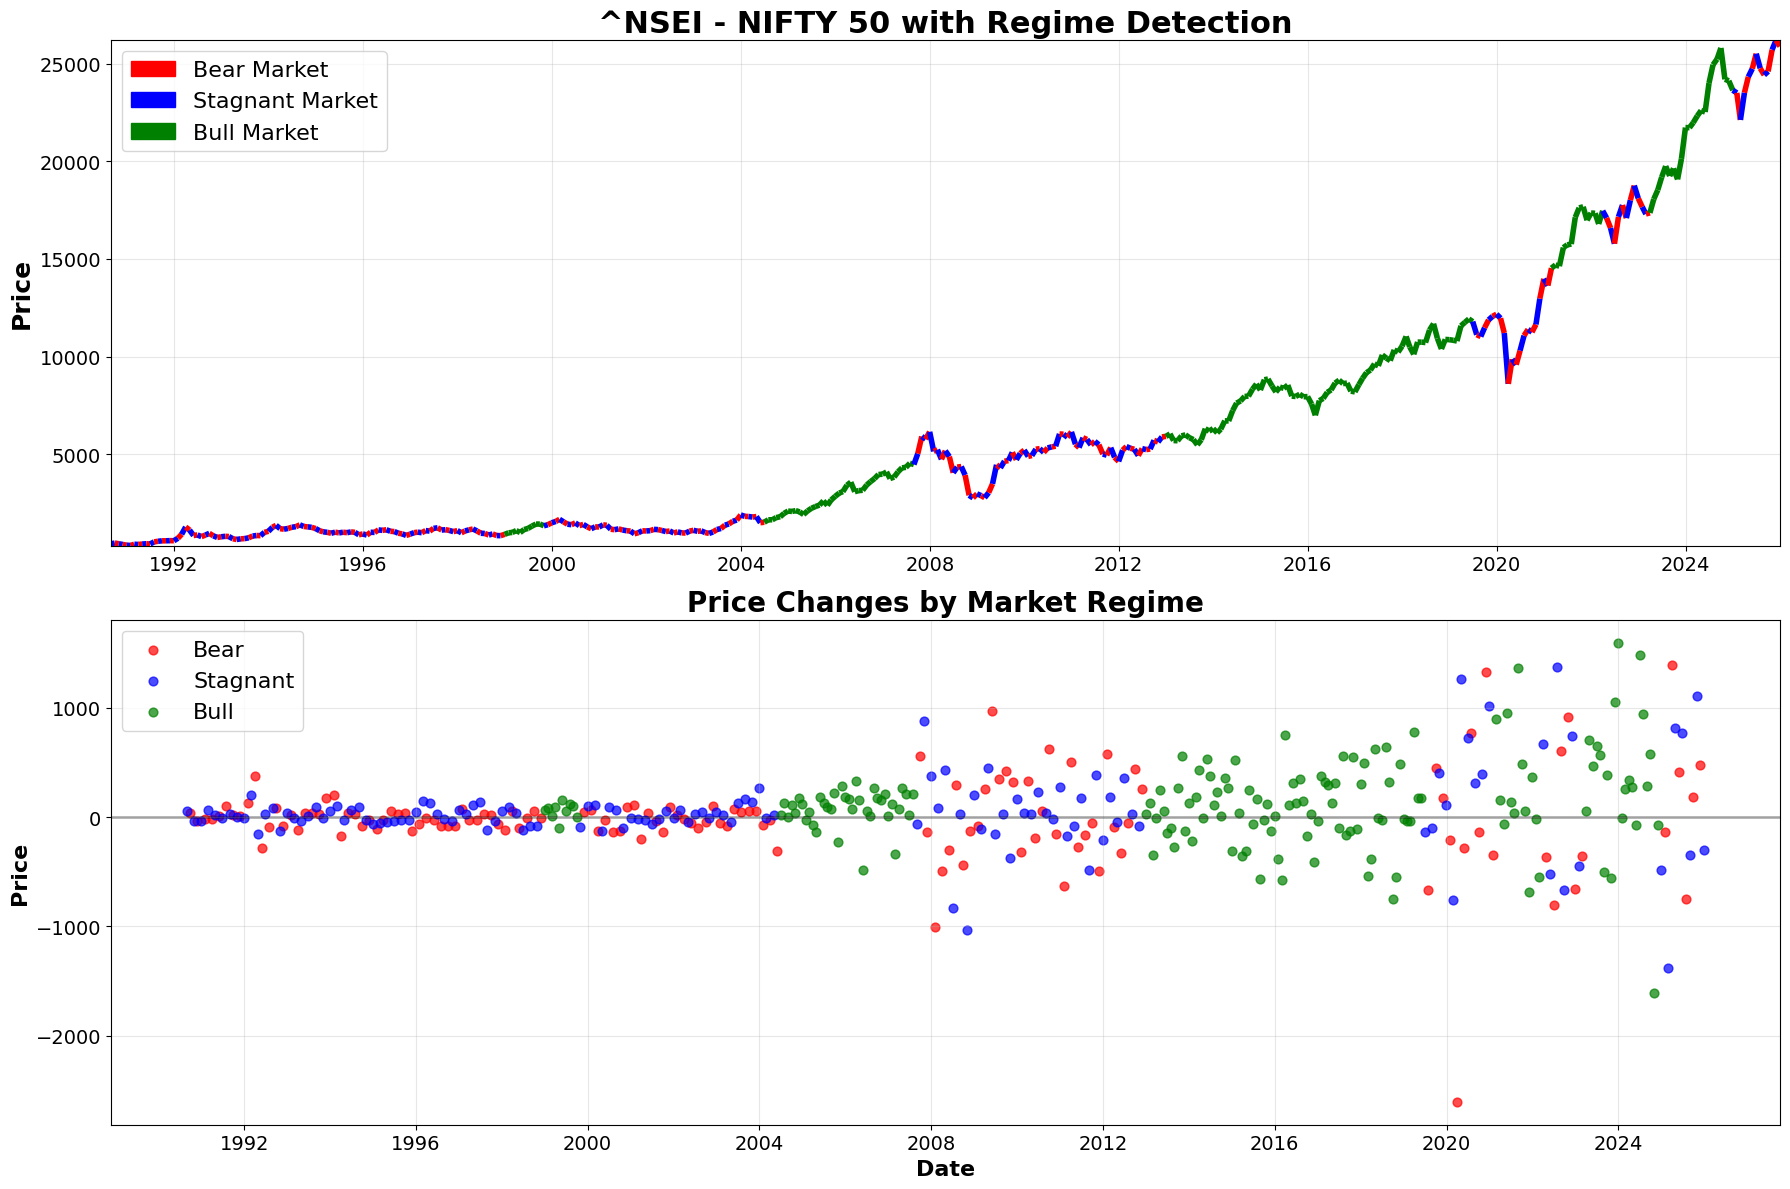

In [392]:
print("\nStep 4.2.4: Interpreting and Mapping Regimes")

# Calculate mean price change for each regime
means = price_with_regimes.groupby(['Regime'])['Price_Diff'].mean()
print("Mean price changes by regime:")
for regime, mean_change in means.items():
    print(f"  State {regime}: {mean_change:.4f}")

# Map regimes to meaningful labels (Bear, Stagnant, Bull)
lst_1 = means.index.tolist()
lst_2 = means.sort_values().index.tolist()  # Sort by mean return

map_regimes = dict(zip(lst_2, [0, 1, 2]))  # 0=Bear, 1=Stagnant, 2=Bull
print(f"Regime mapping: {map_regimes}")

# Apply mapping
price_with_regimes['Regime'] = price_with_regimes['Regime'].map(map_regimes)

# Verify the mapping
final_means = price_with_regimes.groupby(['Regime'])['Price_Diff'].mean()
print("\nFinal regime interpretation:")
regime_labels = {0: 'Bear', 1: 'Stagnant', 2: 'Bull'}
for regime, mean_change in final_means.items():
    label = regime_labels.get(regime, f'State {regime}')
    count = (price_with_regimes['Regime'] == regime).sum()
    print(f"  {label} (State {regime}): {count} observations, mean change: {mean_change:.4f}")

print("\nStep 4.2.5: Creating Regime Visualization")

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# ...existing code...
# Create the multicolored time series plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))  # Bigger figure

# Plot 1: Price with regime coloring
cmap = ListedColormap(['red', 'blue', 'green'], 'indexed')
norm = BoundaryNorm(range(4), cmap.N)

# Convert dates to numerical format for LineCollection
inxval = mdates.date2num(price_with_regimes.index.to_pydatetime())
points = np.array([inxval, price_with_regimes[price_column]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create colored line segments based on regime
lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=4)  # Thicker lines
lc.set_array(price_with_regimes['Regime'])
ax1.add_collection(lc)

# Set plot limits
ax1.set_xlim(price_with_regimes.index.min(), price_with_regimes.index.max())
ax1.set_ylim(price_with_regimes[price_column].min(), price_with_regimes[price_column].max())

# Add legend
r_patch = mpatches.Patch(color='red', label='Bear Market')
b_patch = mpatches.Patch(color='blue', label='Stagnant Market')
g_patch = mpatches.Patch(color='green', label='Bull Market')
ax1.legend(handles=[r_patch, b_patch, g_patch], loc='upper left', fontsize=16)

ax1.set_title(f'{price_column} - NIFTY 50 with Regime Detection', fontsize=22, fontweight='bold')
ax1.set_ylabel('Price', fontweight='bold', fontsize=18)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Regime transitions and statistics
regime_colors = ['red', 'blue', 'green']
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    ax2.scatter(regime_data.index, regime_data['Price_Diff'],
                color=regime_colors[regime], label=regime_labels[regime], alpha=0.7, s=40)  # Slightly larger points

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=2)
ax2.set_title('Price Changes by Market Regime', fontsize=20, fontweight='bold')
ax2.set_xlabel('Date', fontweight='bold', fontsize=16)
ax2.set_ylabel('Price', fontweight='bold', fontsize=16)
ax2.legend(fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# ...existing code...